In [13]:
from tifffile import TiffFile
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
from scipy import optimize
import glob
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.morphology import binary_opening
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from alienlab.regression_func import residuals, exp_decay, regression_affine, regression_linear, get_affine_func

save_folder = '.'
import glob
import alienlab.plot
p = alienlab.plot.PlotFigure()
p.extension = ".pdf"
p.date = False
#p.save_folder = "G:/DREAM/from_github/thesis/Figures/OJIP/"
p.save_folder = "G:/DREAM/from_github/thesis/Intensity_paper/"

sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

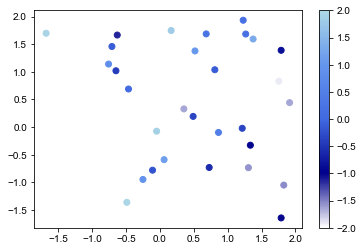

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

x,y,c = zip(*np.random.rand(30,3)*4-2)

cvals  = [-2., -1,0, 1, 2]
colors = ["w","darkblue","royalblue", 'cornflowerblue', 'lightblue']

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
blue_map = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

plt.scatter(x,y,c=c, cmap=blue_map, norm=norm)
plt.colorbar()
plt.show()

In [15]:
def exp_decay(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S= a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    return A * np.exp(-xdata/tau) + y0


def simple_tau(fluo, time_array, sample_rate = 0):
    L = len(time_array) 
    if sample_rate==0:
        sample_rate = L/(time_array[-1]-time_array[0])
    fluo_transition = fluo
    time_transition = np.linspace(0, L - 1, L)
    x0 = [1e5, L/8, 1]
    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                        args = (time_transition, fluo_transition, exp_decay))
    parameters_estimated = OptimizeResult.x
    tau = parameters_estimated[1]

    #conditions on tau too low or too high for the second, more accurate, fit, because we will fit on a signal that lasts 5*tau
    if tau >  L//10: #if too high
        tau =  L//10
    if tau < 3: #if too low, increase it
        tau = 5
    x0 = parameters_estimated #initial guess: parameters from previous fit
    #second fit
    OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                        args = (time_transition[0:int(tau*5)], fluo_transition[0: int(tau*5)], exp_decay))
    parameters_estimated = OptimizeResult.x
    parameters_estimated[1]/=sample_rate

    return parameters_estimated


@delayed
@wrap_non_picklable_objects
def simple_tau_parallel(fluo, time_array, sample_rate = 5):
    return simple_tau(fluo, time_array, sample_rate)[1]

def read_lsm(file):

    with TiffFile(file) as tif:
        volume = tif.asarray()
        #axes = tif.series[0].axes
        lsm_metadata = tif.lsm_metadata
    time = lsm_metadata["TimeStamps"]
    dwell_time = lsm_metadata["ScanInformation"]["Tracks"][0]["PixelTime"]*1e-6
    return volume, time, dwell_time, lsm_metadata

D = 3
def file_analyse(file, plot = False):
    volume, time, dwell_time, lsm_metadata = read_lsm(file)
    intensity = lsm_metadata['ScanInformation']['Tracks'][0]['IlluminationChannels'][0]['Power']
    K = 5
    v_ref = np.mean(volume[0:K], axis = 0)

    if "H2B" in file:
            mask = v_ref > np.mean(v_ref)
            mask = binary_opening(mask)
            #fig = p.image_scale(mask, label = 'mask')
            
            #p.save_name = name  +  "_mask_ref"
            #p.saving(fig)
    else:
            dx = lsm_metadata["DimensionX"]
            dy  = lsm_metadata["DimensionY"]
            px = lsm_metadata["VoxelSizeX"]
            S = 3*1e-6//px + 1
            mask = np.zeros((v_ref.shape))
            V = D
            mask[int(dx//V-S//V):int(dx//V+S//V), int(dy//V-S//V):int(dy//V+S//V)]=1
            mask = mask.astype(bool)
            #fig = p.image_scale(mask, label = 'mask')

            #p.save_name = name  +  "_mask_ref"
            #p.saving(fig)
      
    #plt.figure()
    #plt.imshow(mask)

    volume = volume.reshape(volume.shape[0], -1)
    to_evaluate = volume[:,mask.flatten()]
    fluo = np.mean(to_evaluate, axis = (1))

    params = simple_tau(fluo, time, sample_rate = 1/dwell_time)
    if plot:
        plt.plot(time, fluo, '.')
        plt.plot(time, exp_decay(params, time))
        
    return params[1], intensity, dwell_time




    
def plot_map(I_000, I_000_map, save_name, xlabel, limits = (0,0)):

    if limits==(0,0):
        Q1 = np.quantile(I_000, 0.01)
        Q3 = np.quantile(I_000, 0.95)
    else: 
        Q1 = limits[0]
        Q3 = limits[1]
    I_000_map[I_000_map <= Q1 ] = Q1
    I_000_map[I_000_map >= Q3 ] = Q3
    p.ylabel = "counts"
    p.xlabel = xlabel
    f = p.image_scale(I_000_map, label = xlabel)
    p.save_name = save_name + "_image"
    p.saving(f)
    I_000_distrib = I_000[(I_000>Q1)*(I_000<Q3)].flatten()



    fig = p.set_figure("%d", "%d")
    ax = plt.gca()

    _, bins, _ = plt.hist(I_000_distrib, 15, density= False, alpha=1, facecolor = "white", edgecolor = "black")

    p.save_name = save_name + "_hist"
    p.saving(fig)


    return I_000_map, I_000_distrib

In [16]:
file = glob.glob("D2-H2B/*.lsm")[0]
volume, time, dwell_time, lsm_metadata = read_lsm(file)


dwell time 1.70 µs intensity 5.0 pcent D2-H2B\00-D2-H2B-scan128x128-dwell-1.7us-avg1-00.lsm
dwell time 1.70 µs intensity 5.0 pcent D2-H2B\01-D2-H2B-scan128x128-dwell-1.7us-avg1-01.lsm
dwell time 3.39 µs intensity 5.0 pcent D2-H2B\02-D2-H2B-scan128x128-dwell-3.39us-avg1-02.lsm
dwell time 6.06 µs intensity 0.5 pcent D2-H2B\03-D2-H2B-scan128x128-dwell-6.06us-avg1-03-bqck405-05.lsm
dwell time 6.06 µs intensity 5.0 pcent D2-H2B\03-D2-H2B-scan128x128-dwell-6.06us-avg1-03.lsm
dwell time 8.24 µs intensity 5.0 pcent D2-H2B\04-D2-H2B-scan128x128-dwell-8.24us-avg1-04.lsm
dwell time 1.70 µs intensity 20.0 pcent D2-H2B\05-D2-H2B-scan128x128-dwell-1.70us-laser20-avg1-05.lsm
dwell time 1.70 µs intensity 20.0 pcent D2-H2B\06-D2-H2B-scan128x128-dwell-1.70us-laser20-avg1.lsm
dwell time 1.70 µs intensity 30.0 pcent D2-H2B\07-D2-H2B-scan128x128-dwell-1.70us-laser30-avg1.lsm
dwell time 1.70 µs intensity 10.0 pcent D2-H2B\08-D2-H2B-scan128x128-dwell-1.70us-laser10-avg1.lsm
dwell time 1.70 µs intensity 5.0 p

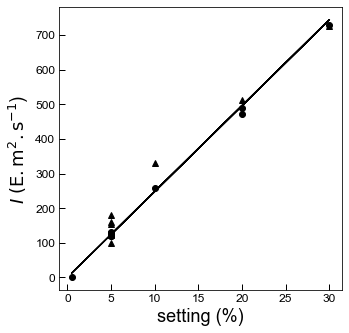

<Figure size 432x288 with 0 Axes>

In [17]:
fig = p.set_figure("%d", "%d")
all_lists = [glob.glob("D2-H2B/*.lsm"),  glob.glob("D2-Solution/*.lsm")]
X = []
Y = []

for i, file_list in enumerate(all_lists):
    for file in file_list:
        if "back" not in file:
            tau, intensity, dwell_time = file_analyse(file)
            I_480 = (1/tau - tau_relax)/sigma_480
            if intensity > 0:
                X.append(intensity)
                Y.append(I_480)
                plt.plot(intensity, I_480, marker = ["o", "^"][i], markeredgecolor='k', color="k" )
            print("dwell time %0.2f µs"%(dwell_time*1e6), "intensity %0.1f pcent"%intensity, file )
X = np.array(X)
Y = np.array(Y)

Yreg, a,  r  = regression_linear(X, Y)
plt.plot(X, Yreg, "k")
print(a)
plt.xlabel("setting (%)")
plt.ylabel(r"$I \; \mathrm{(E.m^2.s^{-1}}$)")
p.save_name = "confocal_calibration"
u = p.saving(fig)

33.69904357135806
D2-Solution/05-D2-DPBS-5uM-laser488-5-dwell3.39us.lsm


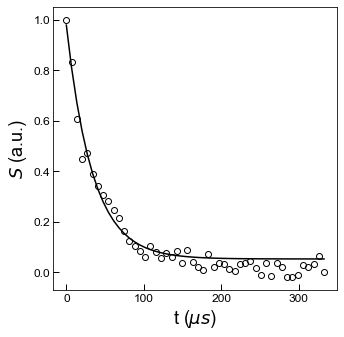

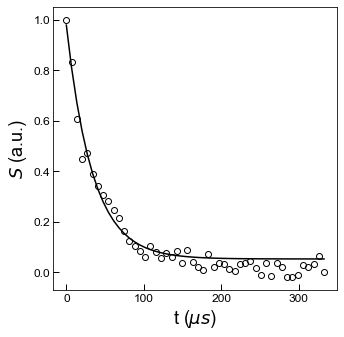

<Figure size 432x288 with 0 Axes>

In [18]:
#fold = ['D2-Solution/01-D2-DPBS-5uM-laser488-5-dwell1.7us.lsm'] 
#fold = ["D2-H2B/09-D2-H2B-scan128x128-dwell-1.70us-laser5-avg1.lsm"]
fold = ['D2-Solution/05-D2-DPBS-5uM-laser488-5-dwell3.39us.lsm']#, 'D2-H2B/02-D2-H2B-scan128x128-dwell-3.39us-avg1-02.lsm']

fig = p.set_figure("%d", "%0.1f")    


for j, file in enumerate(fold):
    name = os.path.split(file)[0]
    if "back" not in file: 
        K = 5
        D = 2
        volume, time, dwell_time, lsm_metadata = read_lsm(file)
        time-=time[0]
        intensity = lsm_metadata['ScanInformation']['Tracks'][0]['IlluminationChannels'][0]['Power']
        v_ref = np.mean(volume[0:K], axis = 0)
        mask = v_ref>np.mean(v_ref)


        im_ref = downscale_local_mean(v_ref, (D, D))

        
        if "H2B" in name:
            mask = im_ref > np.mean(im_ref)
            mask = binary_opening(mask)

        else:
            dx = lsm_metadata["DimensionX"]
            dy  = lsm_metadata["DimensionY"]
            px = lsm_metadata["VoxelSizeX"]
            S = 3*1e-6//px + 1
            mask = np.zeros((im_ref.shape))
            V = 2*D
            mask[int(dx//V-S//V):int(dx//V+S//V), int(dy//V-S//V):int(dy//V+S//V)]=1
            mask = mask.astype(bool)


        video = np.copy(volume)
        video_downscaled = []
        for i in range(video.shape[0]):
            video_downscaled.append(downscale_local_mean(video[i], (D, D)))
        video_downscaled = np.array(video_downscaled)
        init_shape = np.copy(video_downscaled.shape)
        L, H = init_shape[1:]

        video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

        to_evaluate = video_downscaled[:,mask.flatten()]
        
        x = np.linspace(0, len(time)-1, len(time))*dwell_time*1e6
        y= np.mean(to_evaluate, axis = 1)
        m = np.mean(y[-20:])
        y=(y-m)/(y[0]-m)

        params = simple_tau(y, x, sample_rate = 0)
        print(params[1])
        print(file)
        K=2
        y=y[::K]
        x=x[::K]
        plt.plot(x, exp_decay(params, x), 'k')
        plt.plot(x, y, marker = ["o", "^"][j], markeredgecolor="k", color="none",
                label = "dwell_time: %0.1e s, light: %0.1f "%(dwell_time, intensity))
        plt.xlabel(r"t ($\mu s$)")
        plt.ylabel("$S$ (a.u.)")
p.save_name ="solution_3_mean_time_response"
p.saving(fig)



In [19]:
def crop(im, x,y):
    L,H =im.shape
    dl = int((L-x*L)//2)
    dh = int((H-y*H)//2)
    print(dl, dh)
    im = im[dl:L-dl,dh:H-dh]
    return im


v (100, 128, 128)
6 0
(43, 43)
(100, 1849)
38.90134981427741


100%|███████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 381.28it/s]


2 0
2 0


<Figure size 432x288 with 0 Axes>

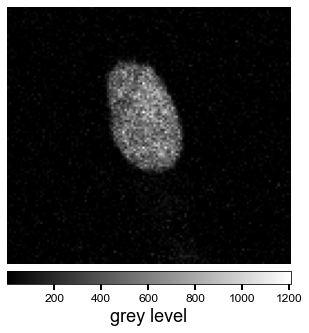

<Figure size 432x288 with 0 Axes>

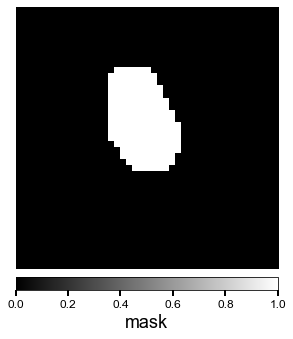

<Figure size 432x288 with 0 Axes>

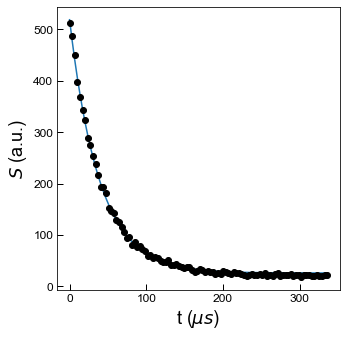

<Figure size 432x288 with 0 Axes>

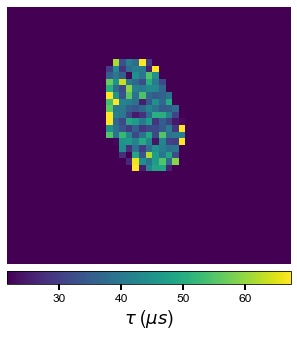

<Figure size 432x288 with 0 Axes>

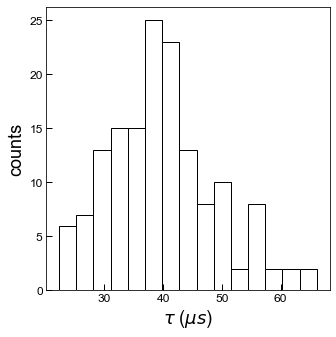

<Figure size 432x288 with 0 Axes>

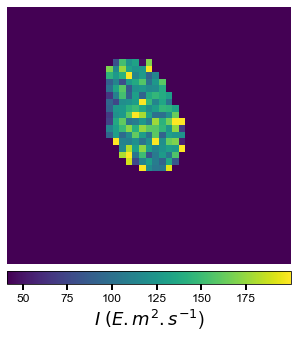

<Figure size 432x288 with 0 Axes>

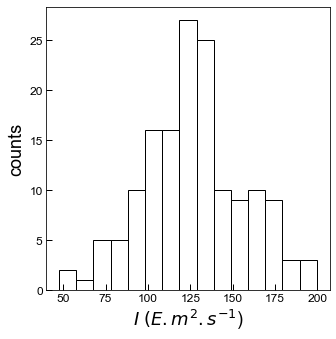

<Figure size 432x288 with 0 Axes>

In [21]:
#fold = ['D2-Solution/01-D2-DPBS-5uM-laser488-5-dwell1.7us.lsm'] 
#fold = ["D2-H2B/09-D2-H2B-scan128x128-dwell-1.70us-laser5-avg1.lsm"]
fold = ['D2-Solution/05-D2-DPBS-5uM-laser488-5-dwell3.39us.lsm']
fold = ['D2-H2B/02-D2-H2B-scan128x128-dwell-3.39us-avg1-02.lsm']



for file in fold:
    name = os.path.split(file)[0]
    if "back" not in file: 
        plt.close('all')
        K = 5
        D = 3
        volume, time, dwell_time, lsm_metadata = read_lsm(file)
        print("v", volume.shape)
        time-=time[0]
        intensity = lsm_metadata['ScanInformation']['Tracks'][0]['IlluminationChannels'][0]['Power']
        v_ref = np.mean(volume[0:K], axis = 0)
        mask = v_ref>np.mean(v_ref)


        im_ref = downscale_local_mean(v_ref, (D, D))
        plt.set_cmap('gray')
        fig = p.image_scale(crop(v_ref, 0.9, 1), label = 'grey level')
        p.save_name = name + '_im_ref_averaging_%d_images'%K
        p.saving(fig)
        
        im_ref = downscale_local_mean(v_ref, (D, D))

        
        if "H2B" in name:
            mask = im_ref > np.mean(im_ref)
            mask = binary_opening(mask)
            fig = p.image_scale(mask, label = 'mask')
            
            p.save_name = name  +  "_mask_ref"
            p.saving(fig)
        else:
            dx = lsm_metadata["DimensionX"]
            dy  = lsm_metadata["DimensionY"]
            px = lsm_metadata["VoxelSizeX"]
            S = 3*1e-6//px + 1
            mask = np.zeros((im_ref.shape))
            V = 2*D
            mask[int(dx//V-S//V):int(dx//V+S//V), int(dy//V-S//V):int(dy//V+S//V)]=1
            mask = mask.astype(bool)
            p.save_name = name  +  "_mask_ref"
            p.saving(fig)

        video = np.copy(volume)
        video_downscaled = []
        for i in range(video.shape[0]):
            video_downscaled.append(downscale_local_mean(video[i], (D, D)))
        video_downscaled = np.array(video_downscaled)
        init_shape = np.copy(video_downscaled.shape)
        L, H = init_shape[1:]

        video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)
        print(mask.shape)
        print(video_downscaled.shape)
        to_evaluate = video_downscaled[:,mask.flatten()]
        
        fig = p.set_figure("%d", "%d")    
        x = np.linspace(0, len(time)-1, len(time))*dwell_time*1e6
        y= np.mean(to_evaluate, axis = 1)
        
        params = simple_tau(y, x, sample_rate = 0)
        print(params[1])
        plt.plot(x, exp_decay(params, x))
        plt.plot(x, y, "ok",
                label = "dwell_time: %0.1e s, light: %0.1f "%(dwell_time, intensity))
        plt.xlabel(r"t ($\mu s$)")
        plt.ylabel("$S$ (a.u.)")
        p.save_name = name + "_mean_time_response"
        p.saving(fig)

        start = 0
        stop = -1
        """
        for i in range(to_evaluate.shape[1]):
                    print(params[1])
                    plt.figure()
                    y, x = to_evaluate[start:stop,i], time[start:stop]
                    params = simple_tau(y, x, sample_rate =  0)
                    plt.plot(x, y)
                    plt.plot(x, exp_decay(params, x), 'k')
                    plt.show()
        """
        
        tau_lists = Parallel(n_jobs = -1 )(simple_tau_parallel(to_evaluate[start:stop,i], time[start:stop], sample_rate = 1/dwell_time) for i in tqdm(range(to_evaluate.shape[1])))
        
        plt.set_cmap('viridis')

        tau_480 = np.array(tau_lists)
        tau_480_map = np.zeros(mask.shape)
        tau_480_map[mask] = tau_480
        I, dis = plot_map(tau_480*1e6, crop(tau_480_map*1e6, 0.9, 1),  name + "_tau_pred", xlabel = r"$\tau$ ($\mu s$)")

        #plt.rcParams['image.cmap'] = blue_map

        I_480 = (1/tau_480 - tau_relax)/sigma_480
        I_480_map = np.zeros(mask.shape)
        I_480_map[mask] = I_480

        I, dis = plot_map(I_480, crop(I_480_map, 0.9, 1),  name + "_intensity_pred", xlabel = r"$I \; (E.m^2.s^{-1}$)")



In [ ]:
video = np.copy(volume)
video_downscaled = []
for i in range(video.shape[0]):
    video_downscaled.append(downscale_local_mean(video[i], (D, D)))
video_downscaled = np.array(video_downscaled)
init_shape = np.copy(video_downscaled.shape)
L, H = init_shape[1:]
video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

to_evaluate = video_downscaled[:,mask.flatten()]

In [27]:
start = 0
stop = -1
tau_lists = Parallel(n_jobs = -1 )(simple_tau_parallel(to_evaluate[start:stop,i], time[start:stop], sample_rate = 1/dwell_time) for i in tqdm(range(to_evaluate.shape[1])))


100%|████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:01<00:00, 3834.52it/s]


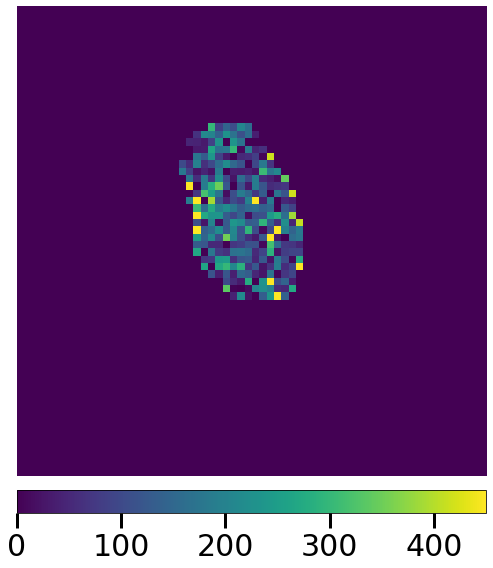

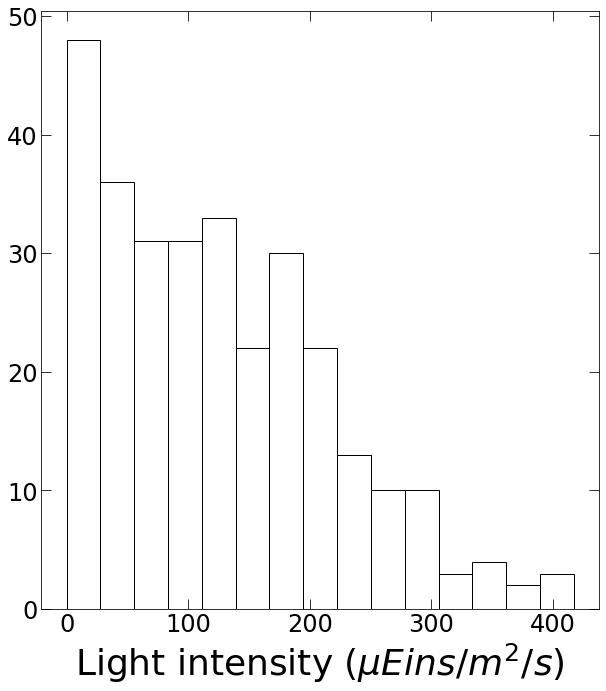

In [119]:
tau_480 = np.array(tau_lists)

I_480 = (1/tau_480 - tau_relax)/sigma_480
I_480_map = np.zeros(mask.shape)
I_480_map[mask] = I_480
 
extension = ".png"
I, dis = plot_map(I_480, I_480_map, "I_480_map_B" + extension, limits = (0, 450))

